# Credit Score Prediction

**Problem statement**

The company provides virtual credit limits to it's customers to meet a wide array of customer financing needs. They want to use the loan data that they have to improve their risk management. They are looking to derive valuable insights from the data and to build a predictive credit score model to aid in future customer credit decisions.

**Data used in this project**
1. Customer loan applications
2. Customer loan details
3. Customer repayment history

**Libraries used**
1. pandas
2. sqlalchemy
3. seaborn
4. matplotlib
5. scikitlearn
6. xgboost

### Preparing a database to query from

In [2]:
import pandas as pd
import sqlalchemy as sa
path = 'data/'

In [3]:
 # Create SQL Alchemy Engine
engine = sa.create_engine('sqlite:///database.db')

In [5]:
# Import data as pd.DataFrame
application_df = pd.read_csv(path + 'application.csv')
loan_df = pd.read_csv(path + 'loan.csv')
payment_df = pd.read_csv(path + 'payment.csv')

In [6]:
# Insert data from pd.DataFrame to SQL Alchemy Engine
application_df.to_sql(name='application', con=engine, if_exists='replace')
loan_df.to_sql(name='loan', con=engine, if_exists='replace')
payment_df.to_sql(name='payment', con=engine, if_exists='replace')

17911

### Creating a function to query from the database instance

In [7]:
def query_from_db(sql_long_string, engine):
    """
    Execute SQL Statement and return the queried data as a pandas.DataFrame object

    :param sql_long_string: SQL statement
    :param engine: SQL Alchemy engine
    """
    statement = engine.execute(sql_long_string)
    df = pd.DataFrame(statement.fetchall())
    df.columns = statement.keys()
    return df

## Data Preparation and Cleaning

### Profiling the datasets

In [8]:
application_df.head()

,Unnamed: 0,cdate,application_id,customer_id,loan_purpose,loan_purpose_desc,dob,address_provinsi,marital_status,dependent,job_type,job_industry
0,0,2021-01-07 13:45:43.876693+00:00,2004025695250,2.003024e+12,Modal usaha,untuk usaha membuat makanan / camilan / kue,2000-01-06,Banten,Lajang,1.0,Pegawai swasta,Admin / Finance / HR
1,1,2021-01-14 15:56:27.403268+00:00,2004025736661,2.003024e+12,Modal usaha,saya ingin menambah modal saya untuk berjualan...,1986-07-22,Banten,Menikah,2.0,Pegawai swasta,Admin / Finance / HR
2,2,2021-02-07 05:21:46.225530+00:00,2004025885365,2.003023e+12,Kebutuhan sehari-hari,banyak pengeluaran bulan ini jadi ngk ketutup ...,NaN,NaN,Lajang,0.0,Pegawai swasta,Pabrik / Gudang
3,3,2021-04-22 07:15:09.482447+00:00,2004026435734,2.003024e+12,Modal usaha,NaN,1996-01-16,Jawa Barat,Menikah,1.0,Pegawai swasta,Pabrik / Gudang
4,4,2021-02-07 14:57:21.120284+00:00,2004025890269,2.003024e+12,Renovasi Rumah,Untuk renovasi rumah yg saat ini ada masalah p...,1992-06-13,NaN,NaN,0.0,Pegawai swasta,Sales / Marketing


In [9]:
application_df.describe()

,Unnamed: 0,application_id,customer_id,dependent
count,497.000000,4.970000e+02,4.510000e+02,444.000000
mean,248.000000,2.004027e+12,2.003023e+12,1.159910
std,143.615807,7.486196e+05,1.177316e+06,1.149783
min,0.000000,2.004026e+12,2.003020e+12,0.000000
25%,124.000000,2.004026e+12,2.003023e+12,0.000000
50%,248.000000,2.004027e+12,2.003024e+12,1.000000
75%,372.000000,2.004027e+12,2.003024e+12,2.000000
max,496.000000,2.004028e+12,2.003025e+12,5.000000


In [10]:
loan_df.head()

,Unnamed: 0,loan_id,loan_amount,loan_duration,installment_amount,fund_transfer_ts,application_id
0,0,2.005021e+12,421632.0,5.0,113000.0,2021-10-28 02:53:53.512501+00:00,2.004027e+12
1,1,2.005021e+12,300000.0,3.0,118000.0,2021-04-10 15:20:20.480261+00:00,2.004026e+12
2,2,2.005021e+12,500000.0,6.0,113000.0,2021-02-23 08:27:53.192023+00:00,2.004026e+12
3,3,2.005021e+12,2500000.0,6.0,566000.0,2021-02-10 02:41:30.887286+00:00,2.004026e+12
4,4,2.005021e+12,500000.0,NaN,196000.0,2021-02-14 01:57:11.613161+00:00,2.004026e+12


In [11]:
loan_df.describe()

,Unnamed: 0,loan_id,loan_amount,loan_duration,installment_amount,application_id
count,5233.00000,5.143000e+03,5.130000e+03,5132.000000,5.131000e+03,5.111000e+03
mean,2616.00000,2.005021e+12,9.333027e+05,3.346843,2.532074e+05,2.004027e+12
std,1510.78131,4.089176e+05,1.672386e+06,2.215034,3.454381e+05,7.096510e+05
min,0.00000,2.005021e+12,8.061000e+03,1.000000,8.888000e+03,2.004026e+12
25%,1308.00000,2.005021e+12,5.368400e+04,1.000000,5.745200e+04,2.004026e+12
50%,2616.00000,2.005021e+12,3.345805e+05,3.000000,1.180000e+05,2.004026e+12
75%,3924.00000,2.005022e+12,1.000000e+06,5.000000,2.850000e+05,2.004027e+12
max,5232.00000,2.005022e+12,1.800000e+07,9.000000,3.360000e+06,2.004028e+12


The `application` dataset contains the loan applications made by the customers, and the `loan` dataset contains the loans given by the company to the customers as a result of their applications.

The primary key of the `application` dataset is `application_id`, while the `loan` dataset's primary key is `loan_id`. In addition, `application_id` is the foreign key of the `loan` dataset.

In [12]:
payment_df.head()

,Unnamed: 0.1,Unnamed: 0,payment_id,payment_number,due_date,due_amount,paid_date,paid_amount,loan_id,dpd
0,0,0,2006021951630,1.0,2021-02-07,0.0,2021-03-08,1026000.0,2.005021e+12,29.0
1,1,1,2006021922761,1.0,2021-02-06,0.0,2021-03-08,152000.0,2.005021e+12,30.0
2,2,2,2006023224658,3.0,2021-10-21,0.0,2021-11-20,1083000.0,2.005021e+12,30.0
3,3,3,2006023527657,2.0,2021-10-21,0.0,2021-11-20,805000.0,2.005021e+12,30.0
4,4,4,2006021922762,2.0,2021-03-06,0.0,NaN,140000.0,2.005021e+12,NaN


In [13]:
payment_df.describe()

,Unnamed: 0.1,Unnamed: 0,payment_id,payment_number,due_amount,paid_amount,loan_id,dpd
count,17911.000000,17911.000000,1.791100e+04,17573.000000,1.756600e+04,1.753500e+04,1.755700e+04,11905.000000
mean,8955.000000,8955.000000,2.006032e+12,2.945086,1.295985e+05,2.456654e+05,2.005021e+12,11.762453
std,5170.604671,5170.604671,1.057963e+07,1.907490,3.254287e+05,3.834782e+05,4.163257e+05,33.248717
min,0.000000,0.000000,2.006022e+12,1.000000,-5.353000e+05,0.000000e+00,2.005021e+12,-230.000000
25%,4477.500000,4477.500000,2.006023e+12,1.000000,0.000000e+00,0.000000e+00,2.005021e+12,6.000000
50%,8955.000000,8955.000000,2.006027e+12,3.000000,0.000000e+00,1.130000e+05,2.005021e+12,26.000000
75%,13432.500000,13432.500000,2.006037e+12,4.000000,1.040000e+05,2.890000e+05,2.005022e+12,29.000000
max,17910.000000,17910.000000,2.006057e+12,13.000000,3.360000e+06,3.776000e+06,2.005022e+12,236.000000


The `payment` dataset contains the payments made by the customers with regards to their loans. The primary key of this dataset is `payment_id`, and `loan_id` is the foreign key that can be used to connect it with the `loan` dataset.

### Combining all the tables into a single dataframe ###

After profiling the data, I handpicked the columns from the joins, so unnamed and duplicate columns are not selected.

In [22]:
query = """
select
    cdate, a.application_id, customer_id, loan_purpose, loan_purpose_desc, dob,
    address_provinsi, marital_status, dependent, job_type, job_industry,
    l.loan_id, loan_amount, loan_duration, installment_amount, fund_transfer_ts,
    payment_id, payment_number, due_date, due_amount, paid_date, paid_amount, dpd
from application a
left join loan l
    on a.application_id = l.application_id
left join payment p1
    on l.loan_id = p1.loan_id
"""
combined_df = query_from_db(query, engine)
combined_df.head()

,cdate,application_id,customer_id,loan_purpose,loan_purpose_desc,dob,address_provinsi,marital_status,dependent,job_type,...,loan_duration,installment_amount,fund_transfer_ts,payment_id,payment_number,due_date,due_amount,paid_date,paid_amount,dpd
0,2021-01-07 13:45:43.876693+00:00,2004025695250,2.003024e+12,Modal usaha,untuk usaha membuat makanan / camilan / kue,2000-01-06,Banten,Lajang,1.0,Pegawai swasta,...,5.0,140000.0,2021-01-24 12:17:45.317242+00:00,2.006022e+12,1.0,2021-03-02,0.0,2021-04-02,149000.0,31.0
1,2021-01-07 13:45:43.876693+00:00,2004025695250,2.003024e+12,Modal usaha,untuk usaha membuat makanan / camilan / kue,2000-01-06,Banten,Lajang,1.0,Pegawai swasta,...,5.0,140000.0,2021-01-24 12:17:45.317242+00:00,2.006022e+12,2.0,2021-04-02,0.0,2021-05-16,195000.0,44.0
2,2021-01-07 13:45:43.876693+00:00,2004025695250,2.003024e+12,Modal usaha,untuk usaha membuat makanan / camilan / kue,2000-01-06,Banten,Lajang,1.0,Pegawai swasta,...,5.0,140000.0,2021-01-24 12:17:45.317242+00:00,2.006022e+12,3.0,2021-05-02,NaN,2021-05-30,140000.0,28.0
3,2021-01-07 13:45:43.876693+00:00,2004025695250,2.003024e+12,Modal usaha,untuk usaha membuat makanan / camilan / kue,2000-01-06,Banten,Lajang,1.0,Pegawai swasta,...,5.0,140000.0,2021-01-24 12:17:45.317242+00:00,2.006022e+12,4.0,2021-06-02,0.0,2021-07-06,140000.0,34.0
4,2021-01-07 13:45:43.876693+00:00,2004025695250,2.003024e+12,Modal usaha,untuk usaha membuat makanan / camilan / kue,2000-01-06,Banten,Lajang,1.0,Pegawai swasta,...,5.0,140000.0,2021-01-24 12:17:45.317242+00:00,2.006022e+12,5.0,None,0.0,2021-08-02,140000.0,NaN


In [15]:
# Loading the combined dataframe to the SQLAlchemy engine
combined_df.to_sql(name='combined', con=engine, if_exists='replace')

16954

### Checking null values

In [16]:
# Check the null columns in the Application dataset
application_df.count()

Unnamed: 0           497
cdate                454
application_id       497
customer_id          451
loan_purpose         441
loan_purpose_desc    443
dob                  453
address_provinsi     439
marital_status       447
dependent            444
job_type             440
job_industry         449
dtype: int64

In [17]:
query = """
select
    count(*) as row_count,
    count(case when cdate is null then 1 end) as null_cdate_count,
    count(case when customer_id is null then 1 end) as null_customer_id_count
from application
"""
df = query_from_db(query, engine)
df.head()

,row_count,null_cdate_count,null_customer_id_count
0,497,43,46


In [18]:
# Check the null columns in the Loan dataset
loan_df.count()

Unnamed: 0            5233
loan_id               5143
loan_amount           5130
loan_duration         5132
installment_amount    5131
fund_transfer_ts      5123
application_id        5111
dtype: int64

In [19]:
query = """
select
    count(*) as row_count,
    count(case when loan_id is null then 1 end) as null_loan_id_count,
    count(case when loan_amount is null then 1 end) as null_loan_amount_count,
    count(case when loan_duration is null then 1 end) as null_loan_duration_count,
    count(case when application_id is null then 1 end) as null_application_id_count
from loan
"""
df = query_from_db(query, engine)
df.head()

,row_count,null_loan_id_count,null_loan_amount_count,null_loan_duration_count,null_application_id_count
0,5233,90,103,101,122


In [20]:
# Check the null columns in the Payment dataset
payment_df.count()

Unnamed: 0.1      17911
Unnamed: 0        17911
payment_id        17911
payment_number    17573
due_date          17512
due_amount        17566
paid_date         12185
paid_amount       17535
loan_id           17557
dpd               11905
dtype: int64

In [21]:
query = """
select
    count(*) as row_count,
    count(case when loan_id is null then 1 end) as null_loan_id_count,
    count(case when due_amount is null then 1 end) as null_due_amount_count,
    count(case when paid_amount is null then 1 end) as null_paid_amount_count
from payment
"""
df = query_from_db(query, engine)
df.head()

,row_count,null_loan_id_count,null_due_amount_count,null_paid_amount_count
0,17911,354,345,376


### Dropping the null values

In [24]:
application_df_clean = application_df.dropna()
loan_df_clean = loan_df.dropna()
payment_df_clean = payment_df.dropna()

### More findings on the data

- The relationship of the datasets is **one-to-many**, as in, one `application_id` has many `loan_id` and one `loan_id` has many `payment_id`.
- The `application` dataset has null values where it should not be, especially **cdate** and **customer_id**.
- The `loan` dataset has null values where it should not be, especially **loan_id**, **loan_amount**, **loan_duration**, and **application_id**.
- The `payment` dataset has null values where it should not be, especially **paid_amount** and **loan_id**.
- In order to use the datasets for modeling, we should drop the nulls.

### Checking for outliers

In [98]:
# Insert data from the cleaned DataFrames to SQL Alchemy Engine
application_df_clean.to_sql(name='application_clean', con=engine, if_exists='replace')
loan_df_clean.to_sql(name='loan_clean', con=engine, if_exists='replace')
payment1_df_clean.to_sql(name='payment1_clean', con=engine, if_exists='replace')
payment2_df_clean.to_sql(name='payment2_clean', con=engine, if_exists='replace')

11004

In [189]:
import seaborn as sns
import matplotlib.pyplot as plt

<AxesSubplot: >

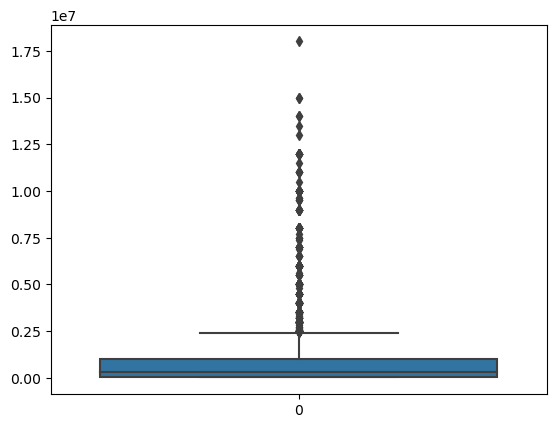

In [69]:
# Drawing boxplots to check for outliers
sns.boxplot(loan_df_clean["loan_amount"])

In [68]:
# Finding the IQR
q1 = loan_df_clean["loan_amount"].quantile(0.25)
q3 = loan_df_clean["loan_amount"].quantile(0.75)
iqr = q3 - q1
print(q1, q3, iqr)

53579.0 1000000.0 946421.0


In [100]:
# Removing the outliers by getting only the non-outliers
query = """
select * from loan
where
    loan_amount >= 53579 - (1.5 * 946421)
    or loan_amount <= 1000000 + (1.5 * 946421)
"""
loan_df_clean = query_from_db(query, engine)

<AxesSubplot: >

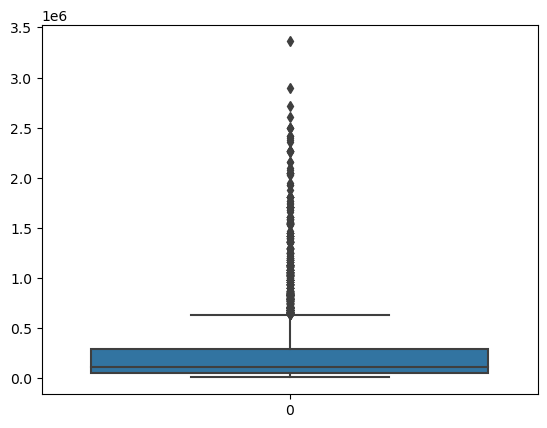

In [63]:
sns.boxplot(loan_df_clean["installment_amount"])

In [94]:
q1 = loan_df_clean["installment_amount"].quantile(0.25)
q3 = loan_df_clean["installment_amount"].quantile(0.75)
iqr = q3 - q1
print(q1, q3, iqr)

57411.75 289000.0 231588.25


In [102]:
query = """
select * from loan
where
    installment_amount >= 57411.75 - (1.5 * 231588.25)
    or installment_amount <= 289000 + (1.5 * 231588.25)
"""
loan_df_clean = query_from_db(query, engine)

<AxesSubplot: >

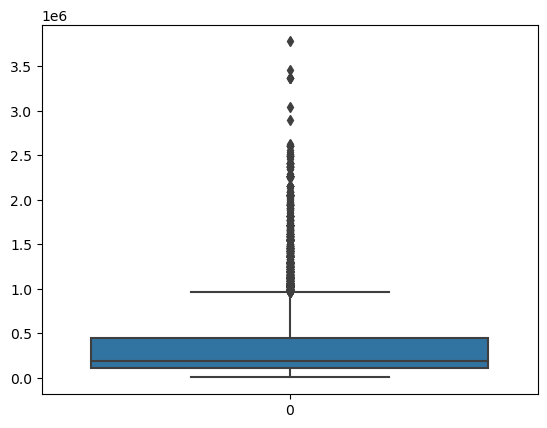

In [64]:
sns.boxplot(payment1_df_clean["paid_amount"])

In [96]:
q1 = payment1_df_clean["paid_amount"].quantile(0.25)
q3 = payment1_df_clean["paid_amount"].quantile(0.75)
iqr = q3 - q1
print(q1, q3, iqr)

106000.0 448000.0 342000.0


In [103]:
query = """
select * from payment1
where
    paid_amount >= 106000 - (1.5 * 342000)
    or paid_amount <= 448000 + (1.5 * 342000)
"""
payment1_df_clean = query_from_db(query, engine)

In [106]:
# Replace the tables after removing outliers
loan_df_clean.to_sql(name='loan_clean', con=engine, if_exists='replace')
payment1_df_clean.to_sql(name='payment1_clean', con=engine, if_exists='replace')
payment1_df_clean.to_sql(name='payment2_clean', con=engine, if_exists='replace')

17535

### Conclusions on the outliers
- The black dots in the box plot are outliers.
- There are no outliers in the `application` dataset since all the fields are categorical.
- **loan_amount** and **installment_amount** in the `loan` dataset seem to have many outliers.
- **paid_amount** and **due_amount** in the `payment` dataset also seem to have many outliers.
- The outliers are removed using the IQR; any values below 1.5 IQR from the 25th percentile and above 1.5 IQR from the 75th percentile are outliers.

## Label Analysis

1. We don't want to give credit to `bad` customers (customers that don't pay at all). Can you define what a `bad` customers is from the dataset provided and what is the earliest indicator to say that a customer is `bad`?
2. Based on the label that you defined, what kind of trends do you see in the data that distinguish good and bad customers?

In [110]:
# Creating a combined dataframe with cleaned data

query = """
select
    cdate, a.application_id, customer_id, loan_purpose, loan_purpose_desc, dob,
    address_provinsi, marital_status, dependent, job_type, job_industry,
    l.loan_id, loan_amount, loan_duration, installment_amount, fund_transfer_ts,
    payment_id, payment_number, due_date, due_amount, paid_date, paid_amount, dpd
from application_clean a
left join loan_clean l
    on a.application_id = l.application_id
left join payment1_clean p1
    on l.loan_id = p1.loan_id
"""
combined_df_clean = query_from_db(query, engine)
combined_df_clean.head()

,cdate,application_id,customer_id,loan_purpose,loan_purpose_desc,dob,address_provinsi,marital_status,dependent,job_type,...,loan_duration,installment_amount,fund_transfer_ts,payment_id,payment_number,due_date,due_amount,paid_date,paid_amount,dpd
0,2021-01-07 13:45:43.876693+00:00,2004025695250,2.003024e+12,Modal usaha,untuk usaha membuat makanan / camilan / kue,2000-01-06,Banten,Lajang,1.0,Pegawai swasta,...,5.0,140000.0,2021-01-24 12:17:45.317242+00:00,2.006022e+12,1.0,2021-03-02,0.0,2021-04-02,149000.0,31.0
1,2021-01-07 13:45:43.876693+00:00,2004025695250,2.003024e+12,Modal usaha,untuk usaha membuat makanan / camilan / kue,2000-01-06,Banten,Lajang,1.0,Pegawai swasta,...,5.0,140000.0,2021-01-24 12:17:45.317242+00:00,2.006022e+12,2.0,2021-04-02,0.0,2021-05-16,195000.0,44.0
2,2021-01-07 13:45:43.876693+00:00,2004025695250,2.003024e+12,Modal usaha,untuk usaha membuat makanan / camilan / kue,2000-01-06,Banten,Lajang,1.0,Pegawai swasta,...,5.0,140000.0,2021-01-24 12:17:45.317242+00:00,2.006022e+12,3.0,2021-05-02,NaN,2021-05-30,140000.0,28.0
3,2021-01-07 13:45:43.876693+00:00,2004025695250,2.003024e+12,Modal usaha,untuk usaha membuat makanan / camilan / kue,2000-01-06,Banten,Lajang,1.0,Pegawai swasta,...,5.0,140000.0,2021-01-24 12:17:45.317242+00:00,2.006022e+12,4.0,2021-06-02,0.0,2021-07-06,140000.0,34.0
4,2021-01-07 13:45:43.876693+00:00,2004025695250,2.003024e+12,Modal usaha,untuk usaha membuat makanan / camilan / kue,2000-01-06,Banten,Lajang,1.0,Pegawai swasta,...,5.0,140000.0,2021-01-24 12:17:45.317242+00:00,2.006022e+12,5.0,None,0.0,2021-08-02,140000.0,NaN


In [112]:
# Loading the cleaned and combined dataframe to the SQLAlchemy engine
combined_df_clean.to_sql(name='combined_clean', con=engine, if_exists='replace')

4763

### Defining bad customer
`Bad` customers (don't pay at all) can be identified by the number of payments they have made. These bad customers have `0` number of payments.

In [143]:
# Counting customers who have loans but never made a payment
query = """
select
    customer_id,
    loan_id,
    count(distinct paid_date) as number_of_payments
from combined_clean
where loan_id is not null
group by 1, 2
having number_of_payments = 0
"""
bad_customer_df = query_from_db(query, engine)
print(bad_customer_df)

      customer_id       loan_id  number_of_payments
0    2.003020e+12  2.005021e+12                   0
1    2.003021e+12  2.005021e+12                   0
2    2.003021e+12  2.005021e+12                   0
3    2.003021e+12  2.005021e+12                   0
4    2.003021e+12  2.005021e+12                   0
..            ...           ...                 ...
222  2.003025e+12  2.005022e+12                   0
223  2.003025e+12  2.005022e+12                   0
224  2.003025e+12  2.005022e+12                   0
225  2.003025e+12  2.005022e+12                   0
226  2.003025e+12  2.005022e+12                   0

[227 rows x 3 columns]


There are 227 customer-loan pairs who don't pay at all.

In [144]:
# Counting customers who have loans and made payments
query = """
select
    customer_id,
    loan_id,
    count(distinct paid_date) as number_of_payments
from combined_clean
where loan_id is not null
group by 1, 2
having number_of_payments > 0
"""
good_customer_df = query_from_db(query, engine)
print(good_customer_df)

       customer_id       loan_id  number_of_payments
0     2.003020e+12  2.005021e+12                   4
1     2.003020e+12  2.005021e+12                   3
2     2.003020e+12  2.005021e+12                   4
3     2.003020e+12  2.005021e+12                   3
4     2.003020e+12  2.005021e+12                   3
...            ...           ...                 ...
1518  2.003025e+12  2.005021e+12                   3
1519  2.003025e+12  2.005021e+12                   3
1520  2.003025e+12  2.005022e+12                   2
1521  2.003025e+12  2.005022e+12                   2
1522  2.003025e+12  2.005022e+12                   2

[1523 rows x 3 columns]


There are 1523 customer-loan pairs who have made payments.

In [145]:
# Loading the bad customer dataframe to the SQLAlchemy engine
bad_customer_df.to_sql(name='bad_customer', con=engine, if_exists='replace')

227

In [152]:
# Getting the profile of bad customers
query = """
select * from application_clean
where customer_id in (select customer_id from bad_customer)
"""
bad_customer_application_df = query_from_db(query, engine)
bad_customer_application_df.head()

,index,Unnamed: 0,cdate,application_id,customer_id,loan_purpose,loan_purpose_desc,dob,address_provinsi,marital_status,dependent,job_type,job_industry
0,0,0,2021-01-07 13:45:43.876693+00:00,2004025695250,2.003024e+12,Modal usaha,untuk usaha membuat makanan / camilan / kue,2000-01-06,Banten,Lajang,1.0,Pegawai swasta,Admin / Finance / HR
1,6,6,2021-01-09 08:56:42.650351+00:00,2004025703643,2.003021e+12,Renovasi Rumah,untuk merenovasi rumah yang saya tempati,1983-03-26,JAWA BARAT,Menikah,2.0,Pegawai swasta,Entertainment / Event
2,12,12,2021-02-05 07:57:43.608429+00:00,2004025871472,2.003024e+12,Biaya kesehatan,biaya kesehatan orang tua di kampung ( transfe...,1999-10-19,DKI Jakarta,Lajang,0.0,Pegawai swasta,Sales / Marketing
3,13,13,2021-04-04 05:05:38.216675+00:00,2004026292493,2.003023e+12,Renovasi Rumah,untuk membangun rumah di kp Tanggeung cianjur ...,1995-02-05,Jawa Barat,Lajang,0.0,Pegawai swasta,Sales / Marketing
4,22,22,2021-02-10 00:11:01.884478+00:00,2004025907167,2.003023e+12,Modal usaha,mau mencoba berwirausaha pempek dan cuanki ger...,1994-02-20,Jawa Barat,Menikah,0.0,Pegawai swasta,Perhotelan


In [153]:
bad_customer_application_df.to_sql(name='bad_customer_application', con=engine, if_exists='replace')

68

In [156]:
# Looking at loan purpose
query = """
select loan_purpose, count(distinct customer_id) as num_of_customers
from bad_customer_application
group by 1 order by 2 desc
"""
df = query_from_db(query, engine)
print(df)

              loan_purpose  num_of_customers
0              Modal usaha                25
1    Kebutuhan sehari-hari                17
2           Renovasi Rumah                 8
3         Biaya pendidikan                 8
4          Biaya kesehatan                 4
5        Membeli kendaraan                 2
6       Membeli elektronik                 2
7  Membayar hutang lainnya                 2


In [167]:
# Looking at age
query = """
select cast(dob as string) as yob, count(distinct customer_id) as num_of_customers
from bad_customer_application
group by 1 order by 2 desc
"""
df = query_from_db(query, engine)
print(df)

     yob  num_of_customers
0   1999                 8
1   1992                 7
2   1991                 5
3   1988                 5
4   1993                 4
5   2000                 3
6   1997                 3
7   1994                 3
8   1989                 3
9   1983                 3
10  1996                 2
11  1995                 2
12  1987                 2
13  1982                 2
14  1981                 2
15  1979                 2
16  1998                 1
17  1990                 1
18  1986                 1
19  1984                 1
20  1980                 1
21  1978                 1
22  1977                 1
23  1976                 1
24  1975                 1
25  1974                 1
26  1972                 1
27  1967                 1


In [158]:
# Looking at address
query = """
select address_provinsi, count(distinct customer_id) as num_of_customers
from bad_customer_application
group by 1 order by 2 desc
"""
df = query_from_db(query, engine)
print(df)

      address_provinsi  num_of_customers
0           Jawa Barat                26
1               Banten                10
2          DKI Jakarta                 9
3          Jawa Tengah                 5
4           Jawa Timur                 4
5     Kalimantan Timur                 2
6          Dki Jakarta                 2
7       Sumatera Utara                 1
8     Sumatera Selatan                 1
9       Sumatera Barat                 1
10    Sulawesi Selatan                 1
11                Riau                 1
12             Lampung                 1
13  Kalimantan Selatan                 1
14          JAWA BARAT                 1
15         DKI JAKARTA                 1
16                Bali                 1


In [159]:
# Looking at marital_status
query = """
select marital_status, count(distinct customer_id) as num_of_customers
from bad_customer_application
group by 1 order by 2 desc
"""
df = query_from_db(query, engine)
print(df)

  marital_status  num_of_customers
0        Menikah                37
1         Lajang                29
2          Cerai                 2


In [161]:
# Looking at dependents
query = """
select dependent, count(distinct customer_id) as num_of_customers
from bad_customer_application
group by 1 order by 2 desc
"""
df = query_from_db(query, engine)
print(df)

   dependent  num_of_customers
0        0.0                29
1        2.0                16
2        1.0                16
3        3.0                 5
4        4.0                 2


In [160]:
# Looking at job type
query = """
select job_type, count(distinct customer_id) as num_of_customers
from bad_customer_application
group by 1 order by 2 desc
"""
df = query_from_db(query, engine)
print(df)

         job_type  num_of_customers
0  Pegawai swasta                60
1  Pegawai negeri                 3
2       Freelance                 3
3       Pengusaha                 2


In [162]:
# Looking at job industry
query = """
select job_industry, count(distinct customer_id) as num_of_customers
from bad_customer_application
group by 1 order by 2 desc
"""
df = query_from_db(query, engine)
print(df)

                  job_industry  num_of_customers
0              Pabrik / Gudang                12
1            Sales / Marketing                11
2         Admin / Finance / HR                10
3                    Kesehatan                 6
4                      Service                 5
5     Konstruksi / Real Estate                 5
6        Entertainment / Event                 5
7                 Transportasi                 4
8            Tehnik / Computer                 3
9                    Perbankan                 3
10                  Perhotelan                 2
11  Hukum / Security / Politik                 2


In [177]:
# Getting the loan profile of bad customers
query = """
select loan_id, loan_amount, loan_duration, installment_amount
from loan_clean
where loan_id in (select loan_id from bad_customer)
"""
bad_customer_loan_df = query_from_db(query, engine)
bad_customer_loan_df.head()

,loan_id,loan_amount,loan_duration,installment_amount
0,2.005022e+12,2052905.0,5.0,574000.0
1,2.005021e+12,53000.0,1.0,57699.0
2,2.005021e+12,10453.0,NaN,11355.0
3,2.005022e+12,53684.0,1.0,58945.0
4,2.005022e+12,26747.0,1.0,27014.0


In [179]:
bad_customer_loan_df.to_sql(name='bad_customer_loan', con=engine, if_exists='replace')

227

In [184]:
# Looking at loan amount
query = """
select round(loan_amount/10000), count(distinct loan_id) as num_of_loans
from bad_customer_loan
group by 1 order by 1
"""
df = query_from_db(query, engine)
print(df)

    round(loan_amount/10000)  num_of_loans
0                        NaN             5
1                        1.0             8
2                        2.0            14
3                        3.0            19
4                        4.0             1
5                        5.0            55
6                        7.0             1
7                        8.0            10
8                       10.0             2
9                       11.0            17
10                      16.0             2
11                      21.0             4
12                      26.0             1
13                      30.0             6
14                      32.0             3
15                      39.0             1
16                      40.0             3
17                      42.0             1
18                      45.0             1
19                      47.0             1
20                      50.0            19
21                      53.0             4
22         

In [185]:
# Looking at loan duration
query = """
select loan_duration, count(distinct loan_id) as num_of_loans
from bad_customer_loan
group by 1 order by 2 desc
"""
df = query_from_db(query, engine)
print(df)

   loan_duration  num_of_loans
0            1.0           109
1            3.0            41
2            6.0            31
3            5.0            17
4            2.0            13
5            4.0             6
6            7.0             5
7            NaN             4
8            9.0             1


In [188]:
# Looking at installment amount
query = """
select round(installment_amount/10000), count(distinct loan_id) as num_of_loans
from bad_customer_loan
group by 1 order by 1
"""
df = query_from_db(query, engine)
print(df)

    round(installment_amount/10000)  num_of_loans
0                               1.0             9
1                               2.0            14
2                               3.0            18
3                               4.0            10
4                               5.0             4
5                               6.0            63
6                               7.0             2
7                               8.0             8
8                               9.0             7
9                              10.0             4
10                             11.0            10
11                             12.0             7
12                             13.0             3
13                             14.0             3
14                             15.0             1
15                             16.0             1
16                             17.0             4
17                             18.0             2
18                             19.0             1


### Indicators of a bad customer
From the simple queries above, we can see that:
- 36.8% of bad customers use the loan for modal usaha, and 25% for kebutuhan sehari-hari
- Age does not seem to be a good indicator for bad customers
- 38.2% of bad customers reside in Jawa Barat
- 54.4% are married and 42.6% are single --> marital status does not seem to be a good indicator
- 47% have 1 or 2 dependents, while 42.6% have no dependents
- 88.2% of them work as pegawai swasta
- 48.5% work in industries like pabrik, sales, admin, marketing, finance, or HR
- 58% of bad loans are amounting to less than 160,000
- 48% of bad loans is only 1 year in duration
- 68.7% of bad loans have installment amount of less than 120,000

## Feature Engineering
Selecting fields that we should use to build the model

In [178]:
query = """
select
    customer_id,
    loan_purpose,
    address_provinsi,
    dependent,
    job_type,
    job_industry,
    avg(loan_amount) as avg_loan_amount,
    avg(loan_duration) as avg_loan_duration,
    avg(installment_amount) as avg_installment_amount
from application_clean a
left join loan_clean l
    on a.application_id = l.application_id
group by 1, 2, 3, 4, 5, 6
"""
features_df = query_from_db(query, engine)
features_df.head()

,customer_id,loan_purpose,address_provinsi,dependent,job_type,job_industry,avg_loan_amount,avg_loan_duration,avg_installment_amount
0,2.003020e+12,Renovasi Rumah,DKI Jakarta,0.0,Pegawai swasta,Admin / Finance / HR,5.789400e+05,4.125000,163500.000000
1,2.003020e+12,Kebutuhan sehari-hari,Sulawesi Selatan,0.0,Pegawai swasta,Transportasi,1.250000e+06,4.500000,349500.000000
2,2.003020e+12,Membeli elektronik,DKI JAKARTA,0.0,Pegawai swasta,Pendidikan,5.000000e+05,6.000000,118000.000000
3,2.003020e+12,Biaya pendidikan,Banten,3.0,Pegawai swasta,Pabrik / Gudang,1.216667e+06,3.666667,402000.000000
4,2.003021e+12,Modal usaha,DKI Jakarta,0.0,Pegawai swasta,Transportasi,7.866652e+05,5.357143,183285.714286


## Data Visualization
Visualizing the data to show that the features are useful

/var/folders/2g/7s767l5511j23r5qcgx2xlyc0000gn/T/ipykernel_35661/3849105655.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = features_df.corr()


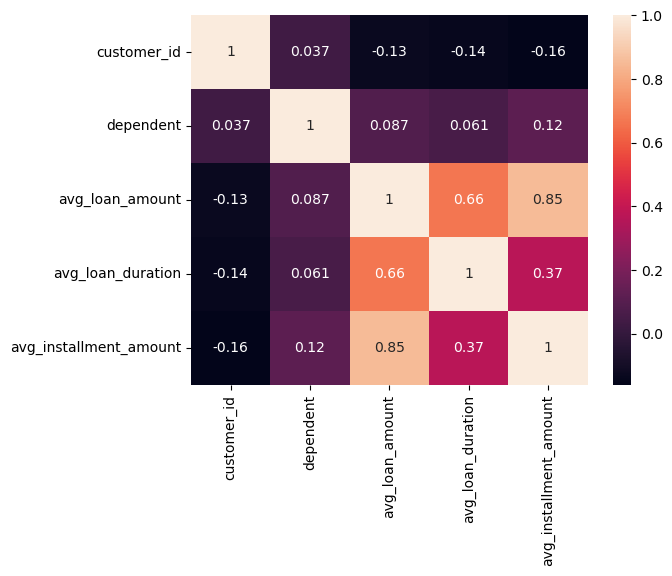

In [191]:
corr_matrix = features_df.corr()
sns.heatmap(corr_matrix, annot=True)
plt.show()

From the heatmap above, we can see that `avg_loan_amount` and `avg_loan_duration` has a quite high correlation of 0.66.
Also, `avg_loan_amount` and `avg_installment_amount` has a high correlation of 0.85.
However, since the correlation is below 0.9, we can still use them in the model.

## Modeling

In [272]:
# Generating the dataset for modeling
query = """
select
    customer_id,
    loan_purpose,
    address_provinsi,
    dependent,
    job_type,
    job_industry,
    avg_loan_amount,
    avg_loan_duration,
    avg_installment_amount,
    case when num_of_payments < 1 then False else True end as label
from (
    select
        customer_id,
        loan_purpose,
        address_provinsi,
        dependent,
        job_type,
        job_industry,
        avg(loan_amount) as avg_loan_amount,
        avg(loan_duration) as avg_loan_duration,
        avg(installment_amount) as avg_installment_amount,
        count(distinct paid_date) as num_of_payments
    from application_clean a
    left join loan_clean l
        on a.application_id = l.application_id
    left join payment1_clean p1
        on l.loan_id = p1.loan_id
    group by 1, 2, 3, 4, 5, 6
)
"""
df = query_from_db(query, engine)
df.head(10)

,customer_id,loan_purpose,address_provinsi,dependent,job_type,job_industry,avg_loan_amount,avg_loan_duration,avg_installment_amount,label
0,2.003020e+12,Renovasi Rumah,DKI Jakarta,0.0,Pegawai swasta,Admin / Finance / HR,5.898296e+05,4.500000,162633.333333,1
1,2.003020e+12,Kebutuhan sehari-hari,Sulawesi Selatan,0.0,Pegawai swasta,Transportasi,1.437500e+06,4.875000,385375.000000,1
2,2.003020e+12,Membeli elektronik,DKI JAKARTA,0.0,Pegawai swasta,Pendidikan,5.000000e+05,6.000000,118000.000000,1
3,2.003020e+12,Biaya pendidikan,Banten,3.0,Pegawai swasta,Pabrik / Gudang,1.336364e+06,4.000000,411818.181818,1
4,2.003021e+12,Modal usaha,DKI Jakarta,0.0,Pegawai swasta,Transportasi,8.594571e+05,5.635135,197297.297297,1
5,2.003021e+12,Modal usaha,DKI JAKARTA,0.0,Pegawai swasta,Admin / Finance / HR,1.228697e+05,1.568779,74261.057927,1
6,2.003021e+12,Biaya pendidikan,DKI Jakarta,0.0,Pegawai swasta,Sales / Marketing,1.258621e+06,4.333333,376482.758621,1
7,2.003021e+12,Biaya kesehatan,Kalimantan Timur,2.0,Pengusaha,Kesehatan,NaN,NaN,NaN,0
8,2.003021e+12,Biaya kesehatan,Jawa Barat,0.0,Pegawai swasta,Sales / Marketing,1.045455e+06,5.545455,244545.454545,0
9,2.003021e+12,Modal usaha,Jawa Barat,2.0,Pegawai swasta,Pabrik / Gudang,5.816892e+05,2.973684,228786.789474,1


In [273]:
# Encoding the categorical variables to integer
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

label_encoder.fit(df['loan_purpose'])
df['loan_purpose'] = label_encoder.transform(df['loan_purpose'])

label_encoder.fit(df['address_provinsi'])
df['address_provinsi'] = label_encoder.transform(df['address_provinsi'])

label_encoder.fit(df['job_type'])
df['job_type'] = label_encoder.transform(df['job_type'])

label_encoder.fit(df['job_industry'])
df['job_industry'] = label_encoder.transform(df['job_industry'])

In [275]:
# Drop customer_id column
df.drop(['customer_id'], axis=1, inplace=True)
df.head()

,loan_purpose,address_provinsi,dependent,job_type,job_industry,avg_loan_amount,avg_loan_duration,avg_installment_amount,label
0,9,5,0.0,2,0,5.898296e+05,4.500000,162633.333333,1
1,4,17,0.0,2,13,1.437500e+06,4.875000,385375.000000,1
2,6,4,0.0,2,6,5.000000e+05,6.000000,118000.000000,1
3,3,2,3.0,2,5,1.336364e+06,4.000000,411818.181818,1
4,8,5,0.0,2,13,8.594571e+05,5.635135,197297.297297,1


In [277]:
# Splitting the dataset
from sklearn.model_selection import train_test_split

X = df.drop(['label'], axis=1)
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [280]:
# Training the model
from xgboost import XGBClassifier

model = XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [281]:
# Making a prediction
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

In [283]:
# Evaluating the prediction using the built-in accuracy metric
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 91.43%


The accuracy of the model is 91.43%. In the real world, anything above 80% or 85% is already good enough.

## Further Improvements

If you have had more time, what would you recommend to further improve the model and why?

1. Check the distribution of the data and find whether it is skewed, and prep it further to fix the skewness
2. Check whether any of the data is imbalanced, and use SMOTE technique to fix it
3. Normalize or standardize the range of the variables used as features
4. Use chi-square and extra tree classifier to check the feature importance of the categorical fields
5. Experiment with other models like logistic regression, decision tree, random forest, KNN, SVM, etc. and compare the results